# 프로젝트명 : 네이버 영화리뷰 감성분석 도전하기

__데이터 준비 및 확인__

In [44]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 불러오기
train_data = pd.read_table('~/aiffel/exploration/E07/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/exploration/E07/sentiment_classification/data/ratings_test.txt')

In [45]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [46]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


### 데이터 로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [47]:
from konlpy.tag import Mecab

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
    train_data = train_data.dropna(how = 'any')  # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')  # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [48]:
# 데이터 로더 실행하여 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)  

In [49]:
index_to_word = {index:word for word, index in word_to_index.items()}  # {인덱스:단어} 딕셔너리 생성

In [50]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_encoded_sentence(sentence, word_to_index) for encoded_sentence in encoded_sentences]

In [51]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('1번째 리뷰 문장 길이: ', len(X_train[0]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
1번째 리뷰 문장 길이:  10


## 데이터 분석 및 패딩

### 데이터 분포 확인

In [52]:
# 텍스트데이터 문장 길이의 리스트를 생성
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2 * 표준편차)로 정한다. (조정 가능)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))  # maxlen=41이 된다. 

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### Padding

RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

In [53]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### Validation set 분리

In [54]:
# validation set 100,000건 분리
X_val = X_train[:46182]
y_val = y_train[:46182]

# validation set을 제외한 나머지
partial_X_train = X_train[46182:]
partial_y_train = y_train[46182:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(100000, 41)
(100000,)


## 모델 설계, 훈련, 평가

### LSTM

In [55]:
# 모델 설계
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 256로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               279552    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 441,617
Trainable params: 441,617
Non-trainable params: 0
_________________________________________________________________


정확도를 올리기 위해 LSTM(8) 에서 조금씩 수치를 높여 LSTM(256) 까지 올려보았다.

__1) LSTM + adam__

In [56]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 11s 49ms/step - loss: 0.6156 - accuracy: 0.6522 - val_loss: 0.3610 - val_accuracy: 0.8426
Epoch 2/10
196/196 [==============================] - 9s 46ms/step - loss: 0.3421 - accuracy: 0.8559 - val_loss: 0.3490 - val_accuracy: 0.8478
Epoch 3/10
196/196 [==============================] - 9s 46ms/step - loss: 0.3149 - accuracy: 0.8709 - val_loss: 0.3524 - val_accuracy: 0.8473
Epoch 4/10
196/196 [==============================] - 9s 46ms/step - loss: 0.3051 - accuracy: 0.8751 - val_loss: 0.3538 - val_accuracy: 0.8485
Epoch 5/10
196/196 [==============================] - 9s 46ms/step - loss: 0.2929 - accuracy: 0.8822 - val_loss: 0.3497 - val_accuracy: 0.8489
Epoch 6/10
196/196 [==============================] - 9s 46ms/step - loss: 0.2752 - accuracy: 0.8901 - val_loss: 0.3489 - val_accuracy: 0.8491
Epoch 7/10
196/196 [==============================] - 9s 47ms/step - loss: 0.2596 - accuracy: 0.8965 - val_loss: 0.3479 - val_accuracy: 0.850

In [57]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3908 - accuracy: 0.8424
[0.3907743990421295, 0.842443585395813]


In [58]:
# 시각화
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


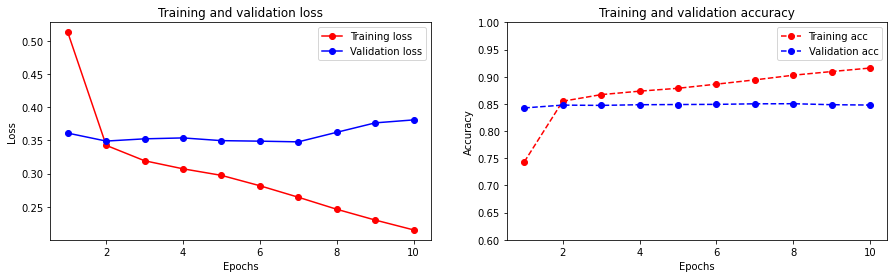

In [59]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='r', marker='o', label='Training loss') # marker
plt.plot(epochs, val_loss, color='b', marker='o', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r--', marker='o', label='Training acc')  # color-- (점선 스타일 옵션)
plt.plot(epochs, val_acc, 'b--', marker='o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.6, 1)
plt.legend()

__2) LSTM + RMSprop__

optimizer를 adam이 아닌 RMSprop을 쓰게 되면 정확도가 더 올라간다는 정보가 있어 optimizer를 변경해보았다.

In [60]:
# 모델 훈련
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 11s 49ms/step - loss: 0.2107 - accuracy: 0.9205 - val_loss: 0.4003 - val_accuracy: 0.8394
Epoch 2/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1873 - accuracy: 0.9288 - val_loss: 0.3948 - val_accuracy: 0.8501
Epoch 3/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1827 - accuracy: 0.9303 - val_loss: 0.4763 - val_accuracy: 0.8454
Epoch 4/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1695 - accuracy: 0.9354 - val_loss: 0.4312 - val_accuracy: 0.8479
Epoch 5/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1707 - accuracy: 0.9345 - val_loss: 0.4025 - val_accuracy: 0.8504
Epoch 6/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1625 - accuracy: 0.9371 - val_loss: 0.4516 - val_accuracy: 0.8416
Epoch 7/10
196/196 [==============================] - 9s 47ms/step - loss: 0.1553 - accuracy: 0.9409 - val_loss: 0.4683 - val_accuracy: 0.847

In [61]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.5171 - accuracy: 0.8351
[0.5170814394950867, 0.8350591063499451]


In [62]:
# 시각화
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


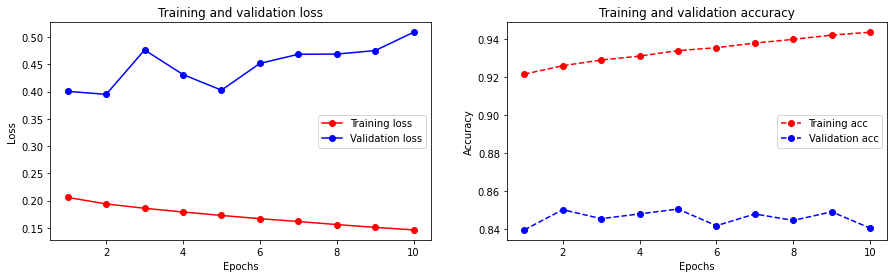

In [63]:
# 시각화
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='r', marker='o', label='Training loss') # marker
plt.plot(epochs, val_loss, color='b', marker='o', label='Validation loss') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r--', marker='o', label='Training acc')  # color-- (점선 스타일 옵션)
plt.plot(epochs, val_acc, 'b--', marker='o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### 1-D CNN

__모델 설계__

In [64]:
vocab_size = 10000
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

__모델 훈련__

In [65]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 2s 8ms/step - loss: 0.6170 - accuracy: 0.6622 - val_loss: 0.3827 - val_accuracy: 0.8310
Epoch 2/10
196/196 [==============================] - 1s 7ms/step - loss: 0.3612 - accuracy: 0.8438 - val_loss: 0.3524 - val_accuracy: 0.8456
Epoch 3/10
196/196 [==============================] - 1s 7ms/step - loss: 0.3243 - accuracy: 0.8631 - val_loss: 0.3427 - val_accuracy: 0.8508
Epoch 4/10
196/196 [==============================] - 1s 8ms/step - loss: 0.3045 - accuracy: 0.8729 - val_loss: 0.3445 - val_accuracy: 0.8505
Epoch 5/10
196/196 [==============================] - 1s 8ms/step - loss: 0.2880 - accuracy: 0.8798 - val_loss: 0.3395 - val_accuracy: 0.8544
Epoch 6/10
196/196 [==============================] - 2s 8ms/step - loss: 0.2703 - accuracy: 0.8902 - val_loss: 0.3378 - val_accuracy: 0.8562
Epoch 7/10
196/196 [==============================] - 2s 8ms/step - loss: 0.2496 - accuracy: 0.8999 - val_loss: 0.3431 - val_accuracy: 0.8559
Epoch 

__모델 평가__

In [66]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4016 - accuracy: 0.8384
[0.40161290764808655, 0.838395357131958]


__시각화__

In [67]:
# 시각화
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


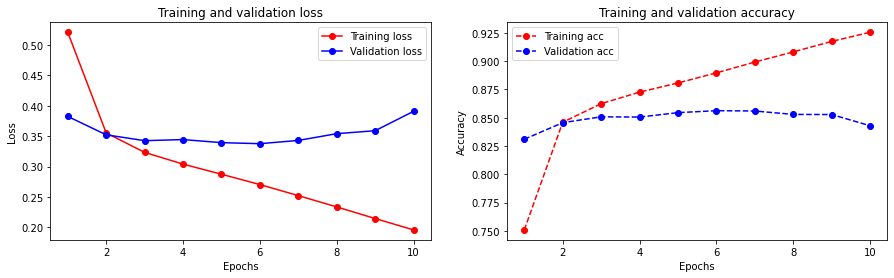

In [68]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='r', marker='o', label='Training loss')
plt.plot(epochs, val_loss, color='b', marker='o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r--', marker='o', label='Training acc')
plt.plot(epochs, val_acc, 'b--', marker='o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### GlobalMaxPooling1D

__모델 설계__

In [69]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


__모델 훈련__

In [70]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 2s 6ms/step - loss: 0.6723 - accuracy: 0.6917 - val_loss: 0.5580 - val_accuracy: 0.7846
Epoch 2/10
196/196 [==============================] - 1s 5ms/step - loss: 0.5155 - accuracy: 0.7961 - val_loss: 0.4175 - val_accuracy: 0.8170
Epoch 3/10
196/196 [==============================] - 1s 5ms/step - loss: 0.3987 - accuracy: 0.8277 - val_loss: 0.3765 - val_accuracy: 0.8325
Epoch 4/10
196/196 [==============================] - 1s 5ms/step - loss: 0.3564 - accuracy: 0.8475 - val_loss: 0.3630 - val_accuracy: 0.8397
Epoch 5/10
196/196 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8560 - val_loss: 0.3567 - val_accuracy: 0.8435
Epoch 6/10
196/196 [==============================] - 1s 5ms/step - loss: 0.3230 - accuracy: 0.8643 - val_loss: 0.3539 - val_accuracy: 0.8455
Epoch 7/10
196/196 [==============================] - 1s 5ms/step - loss: 0.3145 - accuracy: 0.8682 - val_loss: 0.3528 - val_accuracy: 0.8468
Epoch 

__모델 평가__

In [71]:
results = model.evaluate(X_test, y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3663 - accuracy: 0.8423
[0.36630743741989136, 0.8422808647155762]


__시각화__

In [72]:
# 시각화
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


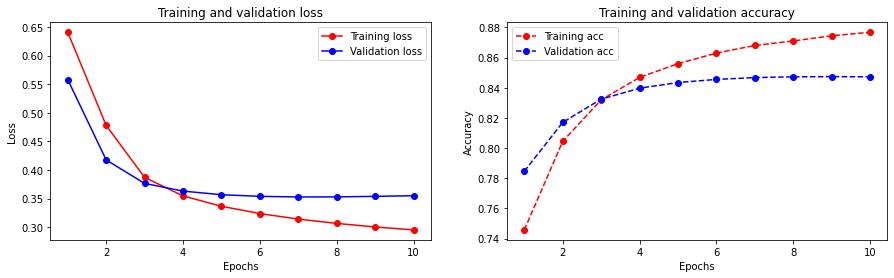

In [73]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='r', marker='o', label='Training loss')
plt.plot(epochs, val_loss, color='b', marker='o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r--', marker='o', label='Training acc')
plt.plot(epochs, val_acc, 'b--', marker='o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## 학습된 Embedding 레이어 분석

In [74]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   # shape: (vocab_size, embedding_dim)

(10000, 16)


In [75]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/exploration/E07/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [76]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

vector = word_vectors['무서운']
vector

array([-0.04191822, -0.09820771,  0.00724678, -0.11781214, -0.07866538,
       -0.09028915, -0.10790052, -0.09761561,  0.00416257, -0.03509455,
        0.00501326, -0.05767121,  0.12388616, -0.07938895, -0.11601929,
       -0.079024  ], dtype=float32)

In [77]:
word_vectors.similar_by_word("무서운")

[('ㅋ', 0.9598186016082764),
 ('But', 0.9473171234130859),
 ('지혜', 0.9403699040412903),
 ('덕', 0.9372261762619019),
 ('더군요', 0.9297573566436768),
 ('숀', 0.929451584815979),
 ('실화', 0.9228657484054565),
 ('옵', 0.9213446378707886),
 ('세상', 0.9165921211242676),
 ('감정', 0.9160683155059814)]

## 한국어 Word2Vec 임베딩 활용 성능 개선

In [78]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME') + '/aiffel/exploration/E07/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['짜증']
vector  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([-0.24589412, -0.2997355 , -0.21933518, -0.6895362 , -0.20709205,
       -0.11269051, -0.20730084,  0.13952582, -0.03920427, -0.03002776,
        0.12838244, -0.4806046 ,  0.24563384,  0.15346129,  0.00095992,
       -0.276586  , -0.06469819, -0.03427793,  0.06423511, -0.41485658,
       -0.18523969,  0.34493387,  0.00390786, -0.03683728, -0.11530887,
        0.08474598,  0.09951345,  0.09378272,  0.3237774 , -0.05825485,
        0.11030284,  0.23983563, -0.5808367 , -0.08091211,  0.13395862,
       -0.20894633,  0.160962  ,  0.13012794,  0.13553406, -0.21047778,
       -0.41025117,  0.16132198,  0.15283999, -0.3526689 ,  0.23549904,
       -0.11868552,  0.23966478,  0.11241938,  0.32805884,  0.13124104,
       -0.21070935,  0.09859888, -0.00323418,  0.04344514, -0.18248425,
       -0.02035202, -0.15306213,  0.23801841,  0.24382284, -0.48005247,
        0.13151534,  0.38227504, -0.18493582,  0.35142717,  0.04102791,
        0.1823288 ,  0.4657583 , -0.09732415, -0.2890572 ,  0.05

In [79]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("짜증")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('싫증', 0.7431163787841797),
 ('흠집', 0.590933620929718),
 ('흉내', 0.5880372524261475),
 ('아물', 0.5121865272521973),
 ('울음소리', 0.5063953995704651),
 ('탄로', 0.4944570064544678),
 ('그러', 0.4920297861099243),
 ('내보', 0.48765820264816284),
 ('악취', 0.48633816838264465),
 ('이거', 0.48398834466934204)]

In [80]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [81]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(256))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [82]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
196/196 [==============================] - 18s 80ms/step - loss: 0.5208 - accuracy: 0.7432 - val_loss: 0.3487 - val_accuracy: 0.8479
Epoch 2/10
196/196 [==============================] - 15s 78ms/step - loss: 0.3308 - accuracy: 0.8593 - val_loss: 0.3447 - val_accuracy: 0.8522
Epoch 3/10
196/196 [==============================] - 15s 78ms/step - loss: 0.2985 - accuracy: 0.8748 - val_loss: 0.3272 - val_accuracy: 0.8604
Epoch 4/10
196/196 [==============================] - 15s 78ms/step - loss: 0.2726 - accuracy: 0.8864 - val_loss: 0.3375 - val_accuracy: 0.8585
Epoch 5/10
196/196 [==============================] - 15s 79ms/step - loss: 0.2466 - accuracy: 0.8978 - val_loss: 0.3349 - val_accuracy: 0.8644
Epoch 6/10
196/196 [==============================] - 15s 78ms/step - loss: 0.2291 - accuracy: 0.9061 - val_loss: 0.3389 - val_accuracy: 0.8654
Epoch 7/10
196/196 [==============================] - 15s 78ms/step - loss: 0.2127 - accuracy: 0.9128 - val_loss: 0.3777 - val_accuracy:

### 모델 평가

In [83]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3925 - accuracy: 0.8551
[0.3925210237503052, 0.8551172614097595]


### 시각화

In [84]:
# 시각화
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


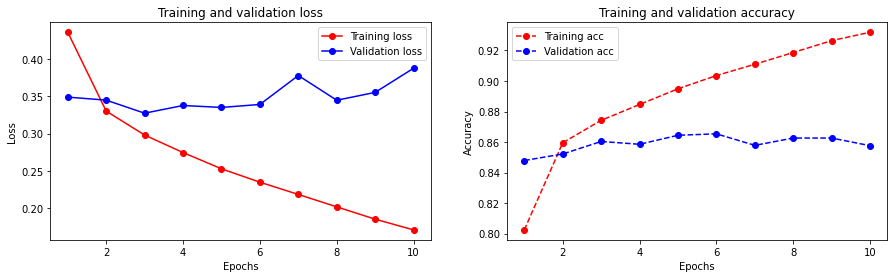

In [85]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='r', marker='o', label='Training loss')
plt.plot(epochs, val_loss, color='b', marker='o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r--', marker='o', label='Training acc')
plt.plot(epochs, val_acc, 'b--', marker='o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## 회고

__모델 학습__
- 노드에서는 epochs을 20으로 주었으나, 학습 횟수가 늘어날 수록 오히려 정확도가 줄어드는 것 같아 epochs를 10 정도로 낮추어 진행하였다.
- opitimizer를 항상 'adam'만 사용해 오다가 'RMSprop'라는게 정확도를 높인다고 해서 처음 사용 하였는데 오히려 'RMSprop' 적용 시 정확도가 낮게 나오는 경우도 있었다. 이 부분을 혹시 내가 잘못 적용한 게 있는지 다시 한번 체크해봐야겠다. 

__모델 학습 결과 시각화__  
- gensim, Word2Vec 등 새로운 자연어 처리 방법을 배웠고, 데이터 분석에서만 시각화를 많이 하는 줄 알았는데 이렇게 모델 학습 결과(loss, accuracy)를 시각화 해서 직관적으로 파악할 수 있다는 사실을 알게 되었다.

__Word2Vec 활용하기__
- Word2Vec 임베딩 학습 전 gensim의 유사단어 찾기를 했을 때 연관성 없는 단어가 많이 나왔다. 그래서 Word2Vec 임베딩 후 다시 유사단어 찾기를 진행하니 기존과 달리 연관성이 높은 단어들이 나왔다. 그래서 정확도에도 뚜렷한 변화가 있을거라 생각했는데, 생각했던 것만큼 놀라운 변화는 없었다.